<a href="https://colab.research.google.com/github/VincentK1991/Sketch2code_with_attention/blob/master/notebook/pre_processing_Jun09_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data pre-processing

The data has 2 components: the sketch image, and the code associated with the HTML for that sketch. Notice here that the code is a .gui meaning it is not written in HTML. Instead we will compile it into HTML using the author compiler codes. The benefit of using the .gui code is that it is concise, and it will be much easier to train model on.

This notebook contains pre-processing steps which consist of
1. downloading the data, unzip, etc.
2. tokenize the text (code) data, add special tokens, and do the padding.
3. pre-processing the images
4. build the training/validation tensor dataset

# 1. download data

- download data
- unzip
- create a dataframe for the file names

In [0]:
import numpy as np
import pandas as pd
import glob
import timeit
import json

In [0]:
!mkdir data

In [0]:
!wget https://s3-us-west-2.amazonaws.com/sketch2code/data.zip -O data/all_data.zip

--2020-05-23 06:40:07--  https://s3-us-west-2.amazonaws.com/sketch2code/data.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.220.32
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.220.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 357684290 (341M) [application/zip]
Saving to: ‘data/all_data.zip’

data/all_data.zip   100%[===================>] 341.11M  19.1MB/s    in 20s     

2020-05-23 06:40:28 (16.7 MB/s) - ‘data/all_data.zip’ saved [357684290/357684290]



In [0]:
!unzip data/all_data.zip -d data/all_data

In [0]:
list_png = glob.glob("data/*.png")

In [0]:
list_png = list(np.sort(list_png))

In [0]:
list_new_gui = [i.replace('png','gui') for i in list_png]

In [0]:
df = pd.DataFrame({'gui':list_new_gui,'png':list_png})

In [0]:
df.tail(5)

,gui,png
1694,data/FDF12CF5-A344-4573-A239-78AE47DBEE78.gui,data/FDF12CF5-A344-4573-A239-78AE47DBEE78.png
1695,data/FDF4126C-C97E-43F0-9624-2AFC2D6BAD69.gui,data/FDF4126C-C97E-43F0-9624-2AFC2D6BAD69.png
1696,data/FE835309-7DF4-4141-B6D1-F0141AC1DBFD.gui,data/FE835309-7DF4-4141-B6D1-F0141AC1DBFD.png
1697,data/FECC1897-8B91-426B-96F3-29DA91E30721.gui,data/FECC1897-8B91-426B-96F3-29DA91E30721.png
1698,data/FEF248A4-868E-4A6C-94D6-9B38A67974F0.gui,data/FEF248A4-868E-4A6C-94D6-9B38A67974F0.png


In [0]:
df.to_csv('all_data_May23_2020.csv')

# 2. Tokenization

- decide if we want to tokenize by "line", or by individual "word".
  - In the end, I found that there are only 11 distinct lines. So that makes tokenizing by line is easier. will help us at the training step because we will have easier time at the embedding step. Doing it by line also make the sequence shorter; therefore, easier to decode. 

## should we tokenize by line or by word, or by characters?

first we need to find out how many unique lines there are.

Then check how many unique words there are.

In [0]:
list_all_line = []
start = timeit.default_timer()
for i in range(1699):
  with open(df['gui'][i], 'r') as file:
    text = file.read().splitlines() 
    file.close()
  for j in text:
    list_all_line.append(j)
  if i%100 == 0:
    stop = timeit.default_timer()
    print('iteration ',i,' takes ',stop - start,' sec')
    start = timeit.default_timer()

iteration  0  takes  0.0024069129999588768  sec
iteration  100  takes  0.1427246240000386  sec
iteration  200  takes  0.13254155399999945  sec
iteration  300  takes  0.130525019000288  sec
iteration  400  takes  0.1343864330001452  sec
iteration  500  takes  7.144379989999834  sec
iteration  600  takes  54.72292397800038  sec
iteration  700  takes  52.04365296300011  sec
iteration  800  takes  52.46960147999971  sec
iteration  900  takes  49.83302759499975  sec
iteration  1000  takes  51.7064525400001  sec
iteration  1100  takes  52.501946879000116  sec
iteration  1200  takes  53.763798638000026  sec
iteration  1300  takes  52.37649783899997  sec
iteration  1400  takes  52.37295009399986  sec
iteration  1500  takes  52.73786095200012  sec
iteration  1600  takes  50.891610609000054  sec


In [0]:
len(np.unique(list_all_line))

11

In [0]:
np.unique(list_all_line)

array(['btn-inactive, btn-inactive',
       'btn-inactive, btn-inactive, btn-inactive',
       'btn-inactive, btn-inactive, btn-inactive, btn-inactive',
       'btn-inactive, btn-inactive, btn-inactive, btn-inactive, btn-inactive',
       'double {', 'header {', 'quadruple {', 'row {', 'single {',
       'small-title, text, btn-orange', '}'], dtype='<U68')

In [0]:
list_all_line[:10]

['header {',
 'btn-inactive, btn-inactive, btn-inactive, btn-inactive',
 '}',
 'row {',
 'single {',
 'small-title, text, btn-orange',
 '}',
 '}',
 'row {',
 'double {']

In [0]:
import re, string

In [0]:
import regex
PUNCT_RE = regex.compile(r'(\p{Punctuation})')   

In [0]:
list_word = []
start = timeit.default_timer()
for i in range(len(list_all_line)):
  temp = PUNCT_RE.split(list_all_line[i])
  for j in np.unique(temp):
    list_word.append(j)
  if i%5000 == 0:
    stop = timeit.default_timer()
    print('iteration ',i,' takes ',stop - start,' sec')
    start = timeit.default_timer()

iteration  0  takes  0.00046440200003416976  sec
iteration  5000  takes  0.08565596499920503  sec
iteration  10000  takes  0.0835987260006732  sec
iteration  15000  takes  0.0796231300000727  sec
iteration  20000  takes  0.07591186700028629  sec
iteration  25000  takes  0.07473752499936381  sec
iteration  30000  takes  0.07823516600001312  sec
iteration  35000  takes  0.07514918200013199  sec
iteration  40000  takes  0.07696402600049623  sec
iteration  45000  takes  0.07841329100028815  sec


In [0]:
len(np.unique(list_word))

17

In [0]:
np.unique(list_word)

array(['', ' btn', ' text', ',', '-', 'btn', 'double ', 'header ',
       'inactive', 'orange', 'quadruple ', 'row ', 'single ', 'small',
       'title', '{', '}'], dtype='<U10')

In [0]:
# list_word_by_gui = []
# start = timeit.default_timer()
# for i in range(len(list_all_line)):
#   temp = PUNCT_RE.split(list_all_line[i])

we have 1699 samples


number of total lines
- 45973
number of unique lines
- 11

```
'header {',
 'btn-inactive, btn-inactive, btn-inactive, btn-inactive',
 '}',
 'row {',
 'single {',
 'small-title, text, btn-orange',
 '}',
 '}',
 'row {',
 'double {'
```

from this it seems like lines are the most appropriate unit of tokenization.



In [0]:
line2idx = {}
idx2line = {}
for count,item in enumerate(np.unique(list_all_line)):
  line2idx[item] = count
  idx2line[count] = item

word2idx = {}
idx2word = {}
for count,item in enumerate(np.unique(list_word)):
  word2idx[item] = count
  idx2word[count] = item

## tokenize by line

In [0]:
list_tokenize_line = []
start = timeit.default_timer()
for i in range(1699):
  with open(df['gui'][i], 'r') as file:
    text = file.read().splitlines() 
    file.close()
  temp_token_list = []
  for j in text:
    temp_token_list.append(line2idx[j])
  list_tokenize_line.append(temp_token_list)

  if i%200 == 0:
    stop = timeit.default_timer()
    print('iteration ',i,' takes ',stop - start,' sec')
    start = timeit.default_timer()

iteration  0  takes  0.0024953600004664622  sec
iteration  200  takes  0.22272874899863382  sec
iteration  400  takes  0.23017073899973184  sec
iteration  600  takes  0.23361632999876747  sec
iteration  800  takes  0.24110647100133065  sec
iteration  1000  takes  0.22023633800017706  sec
iteration  1200  takes  0.21510441899954458  sec
iteration  1400  takes  0.22861869700136594  sec
iteration  1600  takes  0.22360828300043067  sec


## tokenize by words

This is done as a back up. In the end, I didn't use this at all.

In [0]:
list_tokenize_word = []
start = timeit.default_timer()
for i in range(1699):
  with open(df['gui'][i], 'r') as file:
    text = file.read().splitlines() 
    file.close()
  str_text = ''.join(text)
  temp = PUNCT_RE.split(str_text)
  temp_token_list = []
  for j in temp:
    temp_token_list.append(word2idx[j])
  list_tokenize_word.append(temp_token_list)

  if i%200 == 0:
    stop = timeit.default_timer()
    print('iteration ',i,' takes ',stop - start,' sec')
    start = timeit.default_timer()

iteration  0  takes  0.0023877829989942256  sec
iteration  200  takes  0.24466182400101388  sec
iteration  400  takes  0.23397278399897914  sec
iteration  600  takes  0.24120449600013671  sec
iteration  800  takes  0.24266838199946505  sec
iteration  1000  takes  0.24835266699847125  sec
iteration  1200  takes  0.23242362900055014  sec
iteration  1400  takes  0.24015895199954684  sec
iteration  1600  takes  0.24312809200091579  sec


In [0]:
df['tokenized_line'] = list_tokenize_line

In [0]:
df['tokenized_word'] = list_tokenize_word

In [0]:
df.tail(5)

,gui,png,tokenized_line,tokenized_word
1694,data/FDF12CF5-A344-4573-A239-78AE47DBEE78.gui,data/FDF12CF5-A344-4573-A239-78AE47DBEE78.png,"[5, 2, 10, 7, 4, 9, 10, 4, 9, 10, 10, 7, 8, 9,...","[7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 3, 1,..."
1695,data/FDF4126C-C97E-43F0-9624-2AFC2D6BAD69.gui,data/FDF4126C-C97E-43F0-9624-2AFC2D6BAD69.png,"[5, 3, 10, 7, 8, 9, 10, 10, 7, 4, 9, 10, 4, 9,...","[7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 3, 1,..."
1696,data/FE835309-7DF4-4141-B6D1-F0141AC1DBFD.gui,data/FE835309-7DF4-4141-B6D1-F0141AC1DBFD.png,"[5, 1, 10, 7, 4, 9, 10, 4, 9, 10, 10, 7, 8, 9,...","[7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 16, 1..."
1697,data/FECC1897-8B91-426B-96F3-29DA91E30721.gui,data/FECC1897-8B91-426B-96F3-29DA91E30721.png,"[5, 1, 10, 7, 4, 9, 10, 4, 9, 10, 10, 7, 6, 9,...","[7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 16, 1..."
1698,data/FEF248A4-868E-4A6C-94D6-9B38A67974F0.gui,data/FEF248A4-868E-4A6C-94D6-9B38A67974F0.png,"[5, 2, 10, 7, 6, 9, 10, 6, 9, 10, 6, 9, 10, 6,...","[7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 3, 1,..."


In [0]:
df.to_csv('all_tokenized_data_May23_2020.csv')

## add the start <BOS>, end <EOS>, and the padding, to the dictionary and to the tokenized lines

save the dictionary that map the string to index token, and reverse map (index to string). We will need it later.

In [0]:
line2idx['<BOS>'] = 11
idx2line[11] = '<BOS>'

line2idx['<EOS>'] = 12
idx2line[12] = '<EOS>'

line2idx['<PAD>'] = 13
idx2line[13] = '<PAD>'

In [0]:
word2idx['<BOS>'] = 17
idx2word[17] = '<BOS>'

word2idx['<EOS>'] = 18
idx2word[18] = '<EOS>'

word2idx['<PAD>'] = 19
idx2word[19] = '<PAD>'

In [0]:
with open('word2idx.json', 'w') as fp:
    json.dump(word2idx, fp)

with open('idx2word.json', 'w') as fq:
    json.dump(idx2word, fq)

with open('line2idx.json', 'w') as fr:
    json.dump(line2idx, fr)

with open('idx2line.json', 'w') as fs:
    json.dump(idx2line, fs)

Figure out the max length for the line version and for the word version

the line version

max = 45 + 2 for the start and ending

the word version

max = 175 + 2 for the start and ending

In [0]:
padded_tokenized_line = []
for i in list_tokenize_line:
  new_line = [11] + i + [12] + [13]*(47-(len(i) + 2))
  padded_tokenized_line.append(new_line)

In [0]:
len(padded_tokenized_line[1000])

47

In [0]:
padded_tokenized_word = []
for i in list_tokenize_word:
  new_word = [17] + i + [18] + [19]*(177-(len(i) + 2))
  padded_tokenized_word.append(new_word)

In [0]:
len(padded_tokenized_word)

1699

In [0]:
df['tokenized_line'] = padded_tokenized_line

In [0]:
df['tokenized_word'] = padded_tokenized_word

In [0]:
df

,gui,png,tokenized_line,tokenized_word
0,data/00150311-A7AE-4804-8B7D-9273687B4FC0.gui,data/00150311-A7AE-4804-8B7D-9273687B4FC0.png,"[11, 5, 2, 10, 7, 8, 9, 10, 10, 7, 4, 9, 10, 4...","[17, 7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 3..."
1,data/00190F39-0DE9-47EB-B0C2-856FDD3ACE62.gui,data/00190F39-0DE9-47EB-B0C2-856FDD3ACE62.png,"[11, 5, 1, 10, 7, 6, 9, 10, 6, 9, 10, 6, 9, 10...","[17, 7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 1..."
2,data/00779BBE-DD64-4909-9909-24F5C8044A7B.gui,data/00779BBE-DD64-4909-9909-24F5C8044A7B.png,"[11, 5, 2, 10, 7, 8, 9, 10, 10, 7, 6, 9, 10, 6...","[17, 7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 3..."
3,data/011CEB4E-C603-4359-AEA8-D3112A97E9C5.gui,data/011CEB4E-C603-4359-AEA8-D3112A97E9C5.png,"[11, 5, 3, 10, 7, 4, 9, 10, 4, 9, 10, 10, 7, 6...","[17, 7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 3..."
4,data/011D9C15-AF65-4660-B7C9-ECA8676185FE.gui,data/011D9C15-AF65-4660-B7C9-ECA8676185FE.png,"[11, 5, 2, 10, 7, 6, 9, 10, 6, 9, 10, 6, 9, 10...","[17, 7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 3..."
...,...,...,...,...
1694,data/FDF12CF5-A344-4573-A239-78AE47DBEE78.gui,data/FDF12CF5-A344-4573-A239-78AE47DBEE78.png,"[11, 5, 2, 10, 7, 4, 9, 10, 4, 9, 10, 10, 7, 8...","[17, 7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 3..."
1695,data/FDF4126C-C97E-43F0-9624-2AFC2D6BAD69.gui,data/FDF4126C-C97E-43F0-9624-2AFC2D6BAD69.png,"[11, 5, 3, 10, 7, 8, 9, 10, 10, 7, 4, 9, 10, 4...","[17, 7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 3..."
1696,data/FE835309-7DF4-4141-B6D1-F0141AC1DBFD.gui,data/FE835309-7DF4-4141-B6D1-F0141AC1DBFD.png,"[11, 5, 1, 10, 7, 4, 9, 10, 4, 9, 10, 10, 7, 8...","[17, 7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 1..."
1697,data/FECC1897-8B91-426B-96F3-29DA91E30721.gui,data/FECC1897-8B91-426B-96F3-29DA91E30721.png,"[11, 5, 1, 10, 7, 4, 9, 10, 4, 9, 10, 10, 7, 6...","[17, 7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 1..."


In [0]:
df.to_csv('all_PADDED_tokenized_data_May23_2020.csv')

# 3 pre-processing the images

We will use the pre-trained resnet CNN as an encoder. The model was trained on imagenet dataset. We will have to pre-process the image using the normalization values that is used for the imagenet training. 

The image will also be resized to 224x224x3 for height, width, and color channels.

In [0]:
import torch
import torch.nn as nn
import torchvision
from ast import literal_eval
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset

In [0]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

# 4 build the training and validation dataset

Since we have 1699 samples, we will split first 1500 images as the training, and the rest is for validation.

In [0]:
df = pd.read_csv('all_PADDED_tokenized_data_May23_2020.csv',index_col=0).reset_index()

In [0]:
df['tokenized_line'] = df['tokenized_line'].apply(lambda x: literal_eval(x))

In [0]:
df_train = df[:1500]
df_val = df[1500:]

In [0]:
def read_image(frame):
  tensor_image = torch.zeros(len(frame),3,224,224)
  start = timeit.default_timer()
  for count,path in enumerate(frame['png']):
    img = Image.open(path)
    tensor_image[count] = preprocess(img)
    if count % 100 == 0:
      stop = timeit.default_timer()
      print(count,' img read takes ', stop - start,' sec')
      start = timeit.default_timer()
  return tensor_image

def read_token(frame):
  tensor_token = torch.zeros(len(frame),len(frame['tokenized_line'][0]),dtype=torch.long)
  for count,item in enumerate(frame['tokenized_line']):
    tensor_token[count] = torch.tensor(item,dtype=torch.long)
  return tensor_token

def read_caption_len(frame):
  tensor_caption_len = torch.zeros(len(frame),1,dtype=torch.long)
  for count,item in enumerate(frame['tokenized_line']):
    tensor_caption_len[count] = torch.tensor(item.index(12) + 1,dtype=torch.long)
  return tensor_caption_len

In [0]:
train_caption_len = read_caption_len(df_train)
train_tokenized_line = read_token(df_train)
train_img = read_image(df_train)

0  img read takes  0.8155710759999977  sec
100  img read takes  67.709783816  sec
200  img read takes  70.27576345599999  sec
300  img read takes  68.70249990500002  sec
400  img read takes  67.991074121  sec
500  img read takes  69.20323780900003  sec
600  img read takes  65.66472487399994  sec
700  img read takes  77.56558381100001  sec
800  img read takes  66.11869912999998  sec
900  img read takes  69.55573325199998  sec
1000  img read takes  67.46080332700001  sec
1100  img read takes  65.68230352800003  sec
1200  img read takes  67.58827680400009  sec
1300  img read takes  67.1310150249999  sec
1400  img read takes  66.10796358099992  sec


show one image as an example

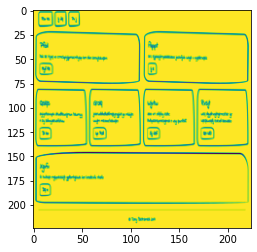

In [0]:
plt.imshow(train_img[600].permute(1,2,0).numpy()[:,:,1])

In [0]:
train_dataset = TensorDataset(train_img,train_tokenized_line,train_caption_len)
torch.save(train_dataset, 'torch_trainFile_Jun07_2020.pt')

### do the same with the validation dataset

In [0]:
df_val = df_val.reset_index()

In [0]:
val_caption_len = read_caption_len(df_val)
val_tokenized_line = read_token(df_val)
val_img = read_image(df_val)

0  img read takes  0.60038739599986  sec
100  img read takes  65.19539972400003  sec


In [0]:
val_dataset = TensorDataset(val_img,val_tokenized_line,val_caption_len)

In [0]:
torch.save(val_dataset, 'torch_valFile_Jun07_2020.pt')